In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

# Alltoall 

In [3]:
df_multinode = pd.read_csv("../data/data-multi-defand100cflag.csv",delimiter = ",")
df_multinode['benchmark_type'].unique()
df_gather = df_multinode[df_multinode["benchmark_type"]=="Scatter"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]
df_gather.columns.tolist()

/tmp/ipykernel_6251/1773704290.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gather = df_multinode[df_multinode["benchmark_type"]=="Scatter"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]
/tmp/ipykernel_6251/1773704290.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_gather = df_multinode[df_multinode["benchmark_type"]=="Scatter"][df_multinode['msg_size_bytes']>1024][df_multinode['off_cache_flag']==-1]


['benchmark_type',
 'proc_num',
 'msg_size_bytes',
 'repetitions',
 't_min_usec',
 't_max_usec',
 't_avg_usec',
 'mpi_datatype',
 'mpi_red_datatype',
 'mpi_red_op',
 'creation_time',
 'n_nodes',
 'off_cache_flag']

/tmp/ipykernel_6251/2016121029.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


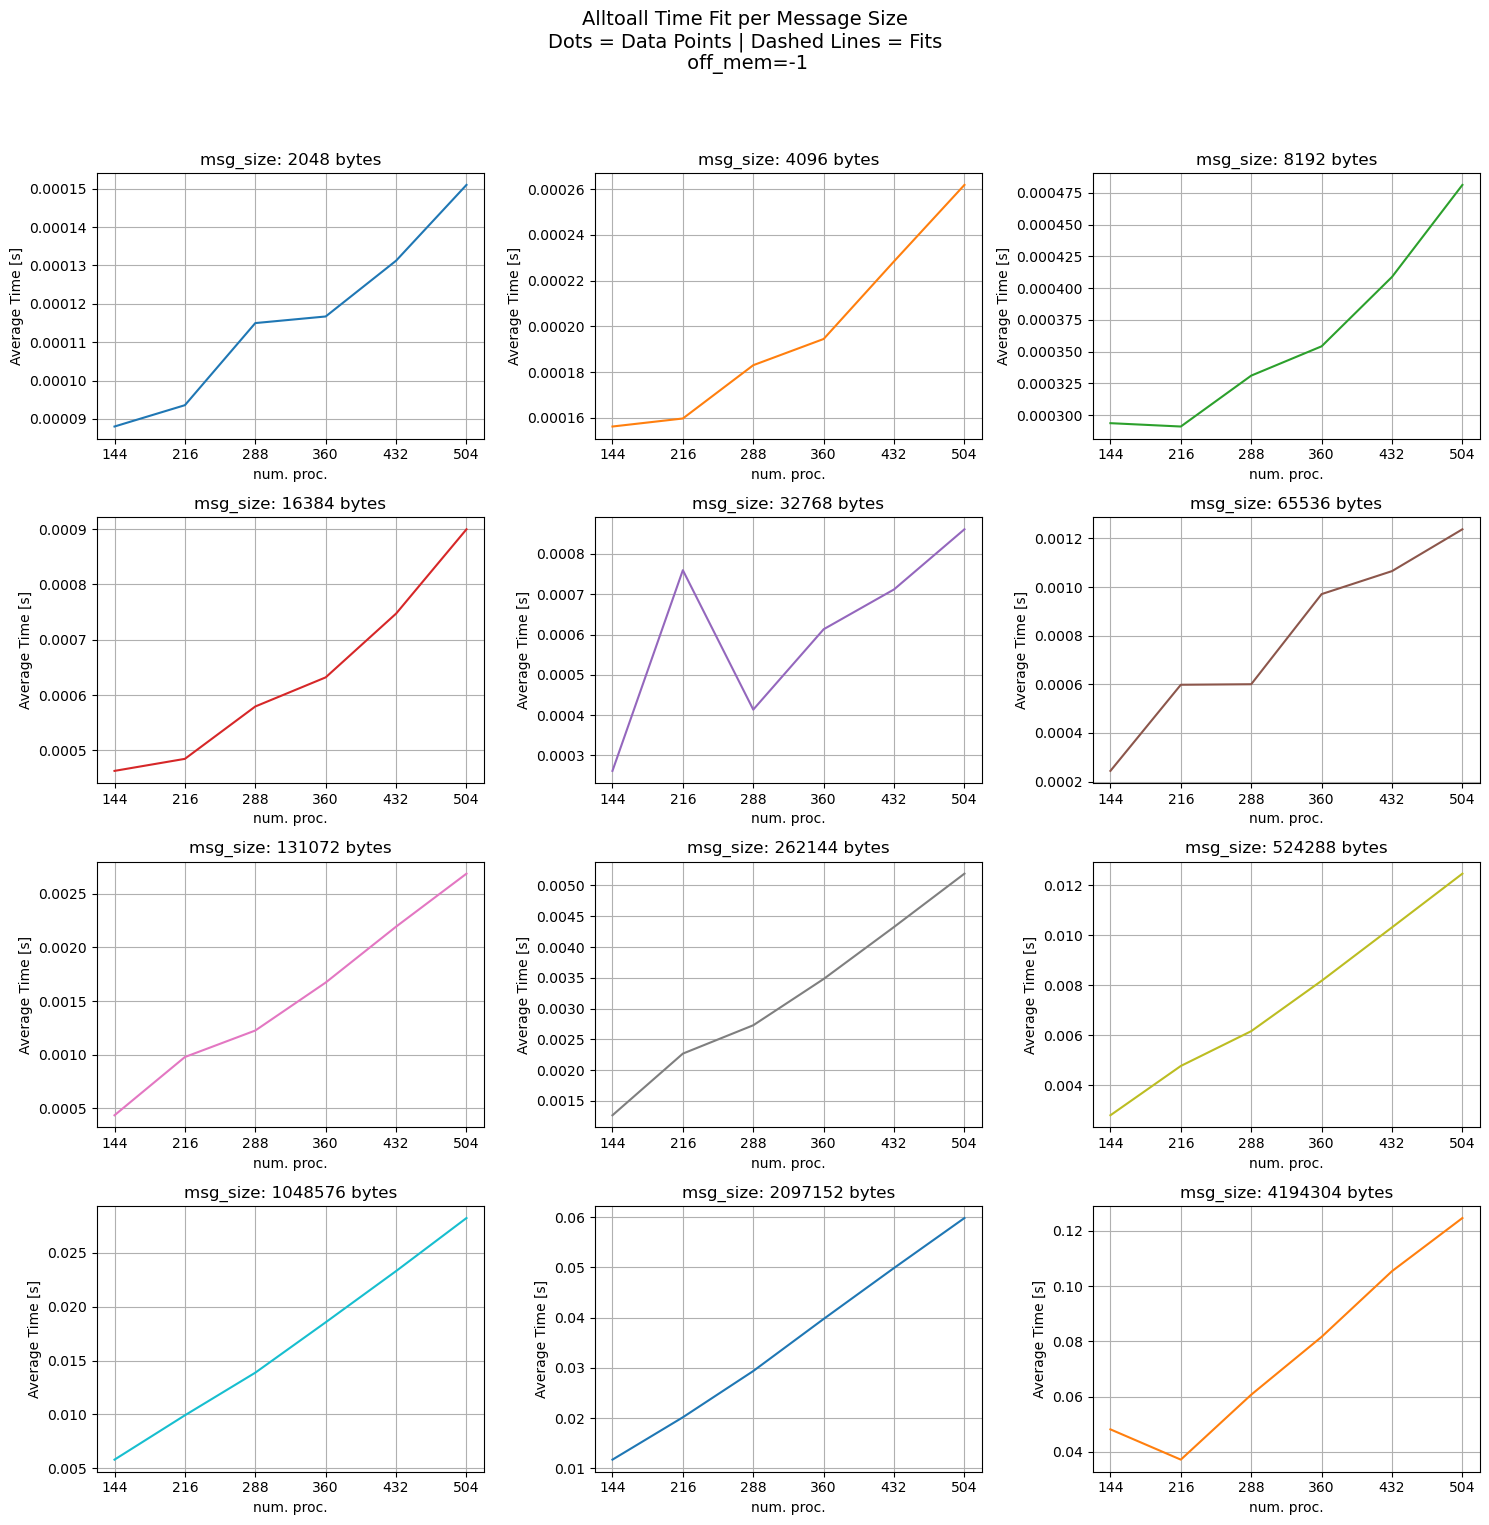

    msg_size_bytes  alpha          beta  inv_alpha
0             2048    1.0  1.653129e-23        1.0
1             4096    1.0  2.784707e-23        1.0
2             8192    1.0  7.739935e-23        1.0
3            16384    1.0  2.497581e-22        1.0
4            32768    1.0  1.052599e-21        1.0
5            65536    1.0  2.254095e-20        1.0
6           131072    1.0  3.401592e-18        1.0
7           262144    1.0  2.229240e-17        1.0
8           524288    1.0  1.527509e-21        1.0
9          1048576    1.0  2.287381e-24        1.0
10         2097152    1.0  1.160941e-16        1.0
11         4194304    1.0  4.068531e-18        1.0


In [6]:
def model(proc_num, alpha, beta, msg_size):
    return (alpha * msg_size * (proc_num - 72) * 72) / (12.5 * 1e3) + 1e6*beta

results = []
msg_sizes = sorted(df_gather['msg_size_bytes'].unique())
n_rows = int(np.ceil(len(msg_sizes) / 3))
n_cols = min(len(msg_sizes), 3)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
cmap = get_cmap('tab10')

for idx, (msg_size, group) in enumerate(df_gather.groupby('msg_size_bytes')):
    x = group['proc_num'].values.copy()
    y = group['t_avg_usec'].values.copy()
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    fit_func = lambda proc_num, alpha, beta: model(proc_num, alpha, beta, msg_size)
    popt, _ = curve_fit(fit_func, x, y, bounds=([1, 0], [np.inf, np.inf]))
    alpha, beta = popt
    results.append({'msg_size_bytes': msg_size, 'alpha': alpha, 'beta': beta})

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = fit_func(x_fit, alpha, beta)
    y_speed = model(x_fit,1,0,msg_size)
    row, col = divmod(idx, n_cols)
    ax = axes[row][col]

    color = cmap(idx % 10)
    # ax.scatter(x, y/1e6, label='Data', color=color)
    ax.plot(x, y/1e6, label='Data', color=color)
    # ax.plot(x_fit, y_fit/1e6, linestyle='--', color=color, alpha=0.5, label='Fit')
    # ax.plot(x_fit, y_speed/1e6, linestyle='--', color='red', alpha=0.1, label='Fit')
    ax.set_title(f'msg_size: {msg_size} bytes')
    ax.set_xlabel('num. proc.')
    ax.set_ylabel('Average Time [s]')
    ax.set_xticks(x)
    ax.grid(True)
    max_data =(x[-1]-72)*72*msg_size
    min_data =(x[0]-72)*72*msg_size

    textstr = ""
    # if(max_data > 1e9):
    #     textstr+=f"max data = {max_data/1e9:0.2f}GB\n" 
    # else:
    #     textstr+=f"max data = {max_data/1e6:0.2f}MB\n" 

    # if(min_data > 1e9):
    #     textstr+=f"min data = {min_data/1e9:0.2f}GB\n" 
    # else:
    #     textstr+=f"min data = {min_data/1e6:0.2f}MB\n" 
    # textstr += r"$\alpha$" +f"= {alpha:.3e}\n"+r"$b_{eff}=$"+f"{12.5/alpha:0.3f}Gbps\n"+\
    #            r"$\beta$"+f"= {beta:.3e} s"
    # ax.text(0.95, 0.05, textstr, transform=ax.transAxes,
    #         fontsize=10, verticalalignment='bottom',
    #         horizontalalignment='right',
    #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Alltoall Time Fit per Message Size\nDots = Data Points | Dashed Lines = Fits\n off_mem=-1', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("plots/alltoall_analysis.png",dpi=300)
plt.show()

fit_results = pd.DataFrame(results)
fit_results['inv_alpha'] = 1 / fit_results['alpha']
print(fit_results)


In [5]:
df_gather[df_gather['msg_size_bytes']==1048576]

benchmark_type  proc_num  msg_size_bytes  repetitions  t_min_usec  \
161         Scatter       288         1048576           40      348.13   
232         Scatter       360         1048576           40     5343.85   
516         Scatter       504         1048576           40     4431.12   
930         Scatter       144         1048576           40      330.36   
1837        Scatter       432         1048576           40      348.51   
2368        Scatter       216         1048576           40     4521.16   

      t_max_usec  t_avg_usec mpi_datatype mpi_red_datatype mpi_red_op  \
161     18588.13    13870.72     MPI_BYTE        MPI_FLOAT    MPI_SUM   
232     24788.75    18554.78     MPI_BYTE        MPI_FLOAT    MPI_SUM   
516     37015.58    28247.29     MPI_BYTE        MPI_FLOAT    MPI_SUM   
930      6271.05     5786.19     MPI_BYTE        MPI_FLOAT    MPI_SUM   
1837    30875.30    23317.92     MPI_BYTE        MPI_FLOAT    MPI_SUM   
2368    12403.88     9908.28     MPI_BYTE        MPI_FLOAT    MPI_SUM   

          creation_time  n_nodes  off_cache_flag  
161   25_07_26_05-44-37        4              -1  
232   25_07_26_05-44-37        5              -1  
516   25_07_26_05-44-37        7              -1  
930   25_07_26_05-44-37        2              -1  
1837  25_07_26_05-44-37        6              -1  
2368  25_07_26_05-44-37        3              -1